In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import pulp as pl
import time

In [6]:
class BipartiteGraph:
    def __init__(self, nU, nW, edges):
        self.nU = nU
        self.U = [i for i in range(0,nU)]
        self.nW = nW
        self.W = [i for i in range(nU,nU+nW)]
        self.edges = [(e[0],e[1]+nU) for e in edges]
        self.inc = {}
        for i in range(0,nU+nW):
            self.inc[i]=[]
        for edge in self.edges:
            self.inc[edge[0]].append(edge[1])
            self.inc[edge[1]].append(edge[0])

    def make_vectors(self, edge_subset):
        vectors=[]
        for e in edge_subset:
            vector=[0 for i in range(0,self.nU+self.nW)]
            vector[e[0]]=1
            vector[e[1]]=-1
            vectors.append(vector)
        return(vectors)

    def all_spanning_trees(self):
        print("csucsszam:",self.nU+self.nW)
        spanning_trees = {} # {tuple a ffa éleivel:fához tartozó vektor}
        degree_sequences_U = {}
        degree_sequences_W = {}
        for edge_subset in itertools.combinations(self.edges, self.nU+self.nW-1): # minden (n-1)-es élrészhalmazra megnézzük bfs-sel, hogy összefüggő-e
            #print("elreszhalmaz:",edge_subset)
            visited=set()
            stack=[edge_subset[0][0]]
            while stack:
                vertex=stack.pop()
                #print("vizsgalt csucs:",vertex,"\nszomszedok:")
                if vertex not in visited:
                    visited.add(vertex)
                    for v in self.inc[vertex]:
                        #print(v)
                        if ((vertex,v) in edge_subset or (v,vertex) in edge_subset) and v not in visited:
                            stack.append(v)
            if len(visited)==self.nU+self.nW:
                spanning_trees[edge_subset]=self.make_vectors(edge_subset)
                #print("!!!!összefüggő")
                degree_sequence_U = [0 for i in range(self.nU)]
                degree_sequence_W = [0 for i in range(self.nW)]
                for edge in edge_subset:
                    degree_sequence_U[edge[0]] += 1
                    degree_sequence_W[edge[1]-self.nU] += 1
                if tuple(degree_sequence_U) in degree_sequences_U:
                    degree_sequences_U[tuple(degree_sequence_U)] += 1
                else:
                    degree_sequences_U[tuple(degree_sequence_U)] = 1
                # ellenőrzés miatt:
                if tuple(degree_sequence_W) in degree_sequences_W:
                    degree_sequences_W[tuple(degree_sequence_W)] += 1
                else:
                    degree_sequences_W[tuple(degree_sequence_W)] = 1
            #else:
                #print("nem összefüggő")
        if len(degree_sequences_U)!=len(degree_sequences_W):
            print("VALAMI BAJ VAN (fokszámsorozatok száma nem egyezik)")
        print("megvannak a feszitofak", time.time()-start_time)
        print("feszitofak szama:",len(spanning_trees))
        return(spanning_trees,len(degree_sequences_U))

    def two_trees_disjoint(self,tree1_vectors,tree2_vectors):
        prob = pl.LpProblem(name="disjoint_trees",
                            sense=pl.LpMinimize)
        idx=[i for i in range(self.nU + self.nW - 1)]
        x = pl.LpVariable.dicts(name="x",
                                lowBound=0.0001, # epszilon
                                indices=idx,
                                cat=pl.LpContinuous)
        y = pl.LpVariable.dicts(name="y",
                                lowBound=0.0001,  # epszilon
                                indices=idx,
                                cat=pl.LpContinuous)
        for i in range(self.nU+self.nW):
            prob += pl.lpSum(x[j]*tree1_vectors[j][i]-y[j]*tree2_vectors[j][i] for j in idx) == 0
        prob += pl.lpSum(x) == 1
        prob += pl.lpSum(y) == 1
        prob.solve(pl.PULP_CBC_CMD(msg=False))

        return(prob.status) # 0: 'Not Solved', 1: 'Optimal', -1: 'Infeasible', -2: 'Unbounded', -3: 'Undefined'


    def find_disjoint_tree_sets(self):
        spanning_trees,nSimplex = self.all_spanning_trees()
        print("szimplexek szama:",nSimplex)
        print("vizsgalunk minden fa-part...")
        intersecting_tree_graph={} # minden feszítőfához hozzárendeljük a tőle diszjunkt feszítőfák halmazát -- nem tudom, hogy így hatékonyabb, vagy úgy, hogy mindig helyben kiszámoljuk, hogy diszjunkt-e
        for tree in spanning_trees.keys():
            intersecting_tree_graph[tree]=set()
        for two_trees in itertools.combinations(spanning_trees.keys(), 2):
            if self.two_trees_disjoint(spanning_trees[two_trees[0]],spanning_trees[two_trees[1]]) == 1: # van közös pontjuk
                #print("hopp, talaltam ket osszelogo feszitofat")
                intersecting_tree_graph[two_trees[0]].add(two_trees[1])
                intersecting_tree_graph[two_trees[1]].add(two_trees[0])
        print("megvan az osszefuggosegi graf", time.time()-start_time)
        #print(intersecting_tree_graph)
        triang=[]
        print("vizsgalunk minden potencialis haromszogelest...")
        for tree_subset in itertools.combinations(spanning_trees.keys(), nSimplex):
            check_subset=1
            for two_trees in itertools.combinations(tree_subset, 2):
                if two_trees[1] in intersecting_tree_graph[two_trees[0]]:
                    check_subset=0
                    break
            if check_subset==1:
                triang.append(tree_subset)
        print("megvannak a haromszogelesek", time.time()-start_time)
        return(triang,len(spanning_trees))

    def draw_triangulations(self,triang,ntrees,draw,distr):
        if distr == 1:
            count_trees = {}
        for t in triang:
            if draw==1:
                fig, axs = plt.subplots(len(t))
                nfig=0
            for edge_subset in t:
                if draw == 1:
                    for i in range(self.nU):
                        axs[nfig].scatter(i,1,color='blue',s=100)
                    for i in range(self.nW):
                        axs[nfig].scatter(i,0,color='blue',s=100)
                    for edge in self.edges:
                        #print(edge)
                        axs[nfig].plot([edge[0],edge[1]-self.nU], [1,0], color='lightgrey')
                    for edge in edge_subset:
                        #print(edge)
                        axs[nfig].plot([edge[0],edge[1]-self.nU], [1,0], color='blue',linewidth=3)
                    nfig+=1
                if distr==1:
                    if edge_subset in count_trees.keys():
                        count_trees[edge_subset] += 1
                    else:
                        count_trees[edge_subset] = 1
        if draw==1:
            plt.show()
        if distr==1:
            sorted_trees=sorted(count_trees.items(), key=lambda x: x[1], reverse=True)
            for tree,count in sorted_trees:
                print(tree,"--",count)
            if len(count_trees)!=ntrees:
                print(ntrees-len(count_trees),"darab fa nincs haromszogelesben")


In [7]:
start_time=time.time()
G=BipartiteGraph(2,2,[(0,0),(0,1),(1,0),(1,1)]) # K_2,2
G2=BipartiteGraph(2,3,[(0,0),(0,1),(1,0),(1,1),(0,2)]) # K_2,2 plusz egy levél
G3=BipartiteGraph(2,3,[(0,0),(0,1),(1,1),(0,2)]) # fa -- kirajzoló nem működik valamiért
G4=BipartiteGraph(5,5,[(0,0),(0,1),(1,0),(1,1),(0,2),(0,3),(1,4),(2,2),(2,3),(3,2),(4,4)])
G5=BipartiteGraph(3, 3, [(i, j) for i in range(3) for j in range(3)[:i+1]])
G6=BipartiteGraph(3, 3, [(i, j) for i in range(3) for j in range(3)])
            # megvannak a feszitofak 0.00099945068359375
            # szimplexek szama: 6
            # megvan az osszefuggosegi graf 80.98899555206299
            # megvan a haromszogeles 250.6303060054779
G7=BipartiteGraph(4, 4, [(i, j) for i in range(4) for j in range(4)])
G8=BipartiteGraph(5, 5, [(i, j) for i in range(5) for j in range(5)]) # K_5,5 -- all_spanning_trees lefutott pár perc alatt
G9=BipartiteGraph(3,3, [(0,1),(0,2),(1,0),(1,2),(2,1),(2,2),(2,0),(0,0)])



csucsszam: 4
megvannak a feszitofak 498.8823628425598
feszitofak szama: 4
szimplexek szama: 2
vizsgalunk minden fa-part...
megvan az osszefuggosegi graf 499.801465511322
vizsgalunk minden potencialis haromszogelest...
megvannak a haromszogelesek 499.801465511322


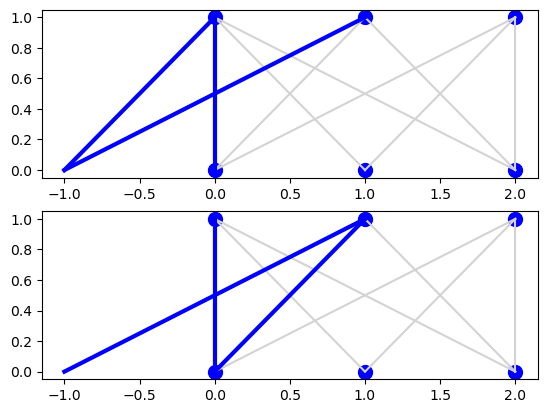

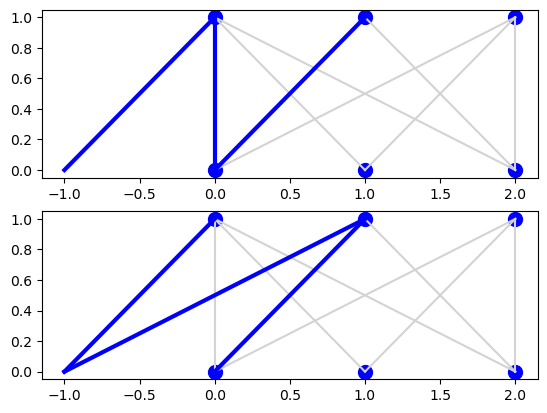

((0, 2), (0, 3), (1, 2)) -- 1
((0, 3), (1, 2), (1, 3)) -- 1
((0, 2), (0, 3), (1, 3)) -- 1
((0, 2), (1, 2), (1, 3)) -- 1


In [9]:
triang,ntrees=G.find_disjoint_tree_sets()
G9.draw_triangulations(triang,ntrees,1,1)